## Подготовка

Импортируем необходимые для работы библиотеки:

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split as tts
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn import metrics as sklm

Откроем файл и проанализируем данные:

In [2]:
df = pd.read_csv('/datasets/taxi.csv')

In [3]:
print(df.head())
df.info()

              datetime  num_orders
0  2018-03-01 00:00:00           9
1  2018-03-01 00:10:00          14
2  2018-03-01 00:20:00          28
3  2018-03-01 00:30:00          20
4  2018-03-01 00:40:00          32
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Добавим в датасет список номеров а также определим столбец `num_orders` типом `datetime`

In [4]:
del df
df = pd.read_csv('/datasets/taxi.csv', index_col = [0], parse_dates = [0])
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Проверим монотонность индекса:

In [5]:
df.index.is_monotonic

True

Проверим данные на пропуски:

In [6]:
df.isna().sum()

num_orders    0
dtype: int64

Проведем ресемплирование по одному часу:

In [7]:
df = df.resample('1H').sum()

## Анализ

### Анализ данных за весь период

Построим график заказов и проанализируем его:

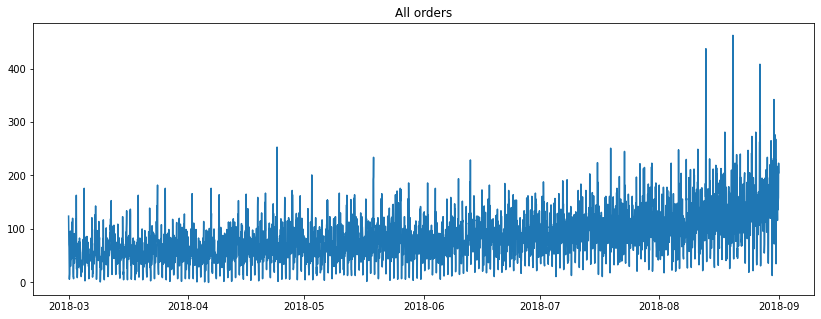

In [8]:
plt.figure(figsize = (14, 5))
plt.plot(df)
plt.title('All orders')
plt.show()

На первый взгляд, график с марта по июнь - статический, далее - нестатический

Добавим плавающее среднее и стандартное отклонение:

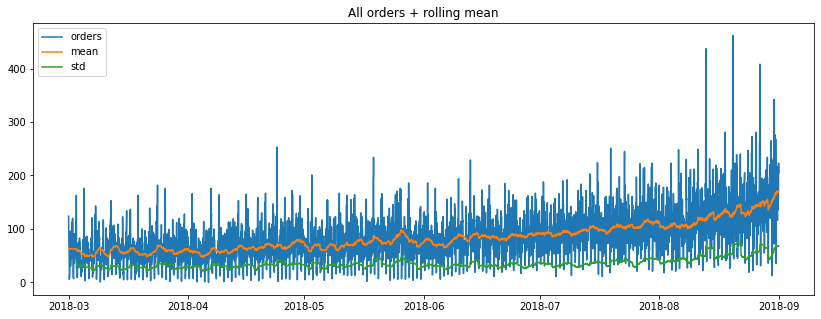

In [9]:
df['rolling_mean'] = df.rolling(50).mean()
df['rolling_mean'] = df['rolling_mean'].fillna(method = 'bfill')
df['std'] = df['num_orders'].rolling(50).std()

plt.figure(figsize = (14, 5))
plt.plot(df)
plt.legend(('orders', 'mean', 'std'))
plt.title('All orders + rolling mean')
plt.show()

Разложим временной ряд на тренд, сезонность и остаток:

In [10]:
del df['rolling_mean'], df['std']

In [11]:
decomposed = seasonal_decompose(df)

df_trend = decomposed.trend
df_season = decomposed.seasonal
df_residual = decomposed.resid

### Анализ данных по тренду, сезонности и остатку

Построим графики для тренда, сезонности и остатка:

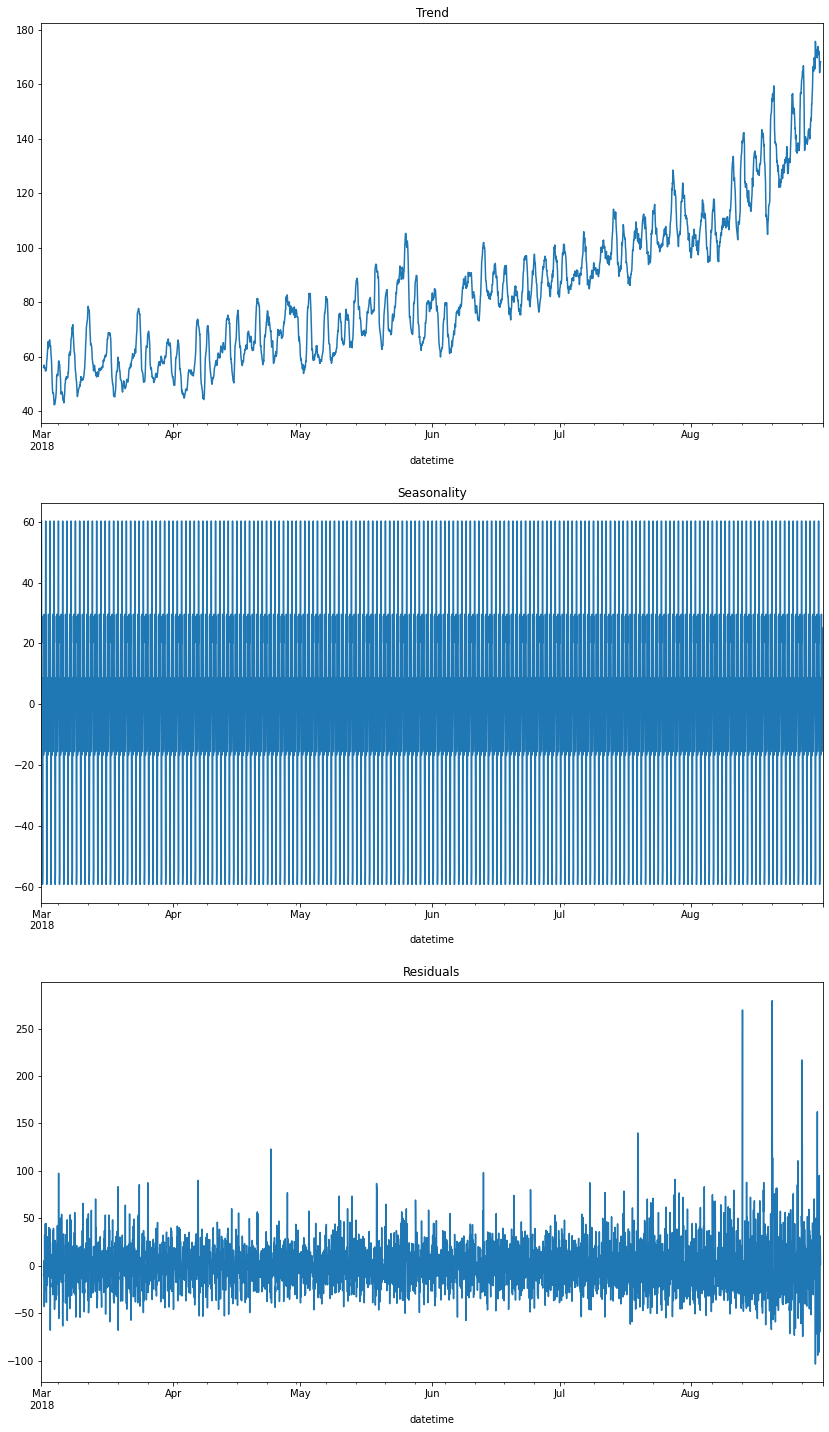

In [12]:
plt.figure(figsize = (14, 25))
plt.subplot(311);
df_trend.plot(ax = plt.gca());
plt.title('Trend');

plt.subplot(312);
df_season.plot(ax = plt.gca());
plt.title('Seasonality');

plt.subplot(313);
df_residual.plot(ax = plt.gca());
plt.title('Residuals');

Из полученных графиков можно сделать выводы:

1. Количество заказов постоянно увеличивается (минимум - в марте, максимум - в сентябре)
2. Сезонность постоянная и колебается с амплитудой 60 (необходимо уточнить)
3. Остатки примерно до августа колебаются в одинаковом диапазоне (амплитуда примерно 35-40), далее к сентябрю амплитуда увеличивается примерно до 50, а также увеличиваются случайные значения

Для получения более ясной картины исследуем более детально тренды и сезонности для несколько периодов: неделя в марте и неделя в августе

### Анализ данных в отдельных периодах

Возьмем неделю в марте с `2018-03-15` по `2018-03-22`. Определим, какой день недели было 15 марта:

In [13]:
df['2018-03-15'].index.dayofweek

/tmp/ipykernel_346/3255100094.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  df['2018-03-15'].index.dayofweek


Int64Index([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
            3, 3],
           dtype='int64', name='datetime')

15 марта - четверг. Построим графики для тренда (неделя с 15 по 22 марта) и сезонности (16 марта):

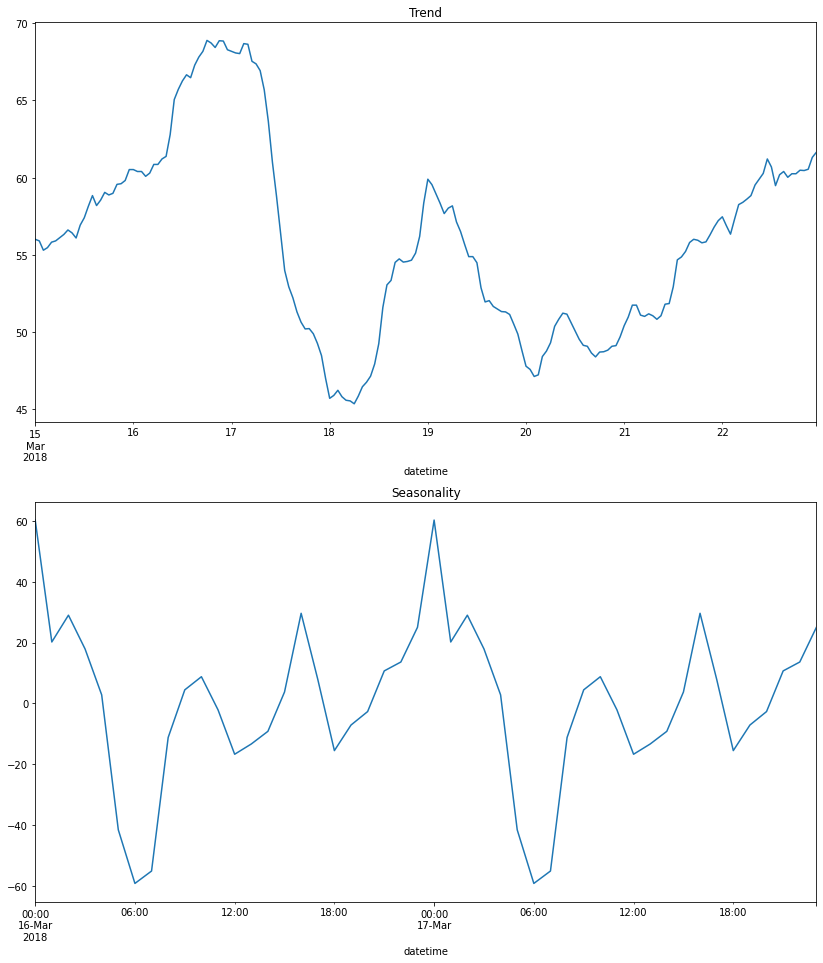

In [14]:
plt.figure(figsize = (14, 25))
plt.subplot(311);
df_trend['2018-03-15' : '2018-03-22'].plot(ax = plt.gca());
plt.title('Trend');

plt.subplot(312);
df_season['2018-03-16' : '2018-03-17'].plot(ax = plt.gca());
plt.title('Seasonality');

Можно сделать выводы, что:
    
1. Пик поездок по дням недели приходится на пятницу и субботу, минимум - на воскресенье
2. Пики поездок по времени - в 17 и полночь, минимум - в 6 утра

Возьмем неделю в августе с `2018-08-13` по `2018-08-20`. Определим, какой день недели было 13 марта:

In [15]:
df['2018-08-20'].index.dayofweek

/tmp/ipykernel_346/4011640874.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  df['2018-08-20'].index.dayofweek


Int64Index([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            0, 0],
           dtype='int64', name='datetime')

13 августа - понедельник. Построим графики для тренда (неделя с 13 по 20 августа) и сезонности (15 марта):

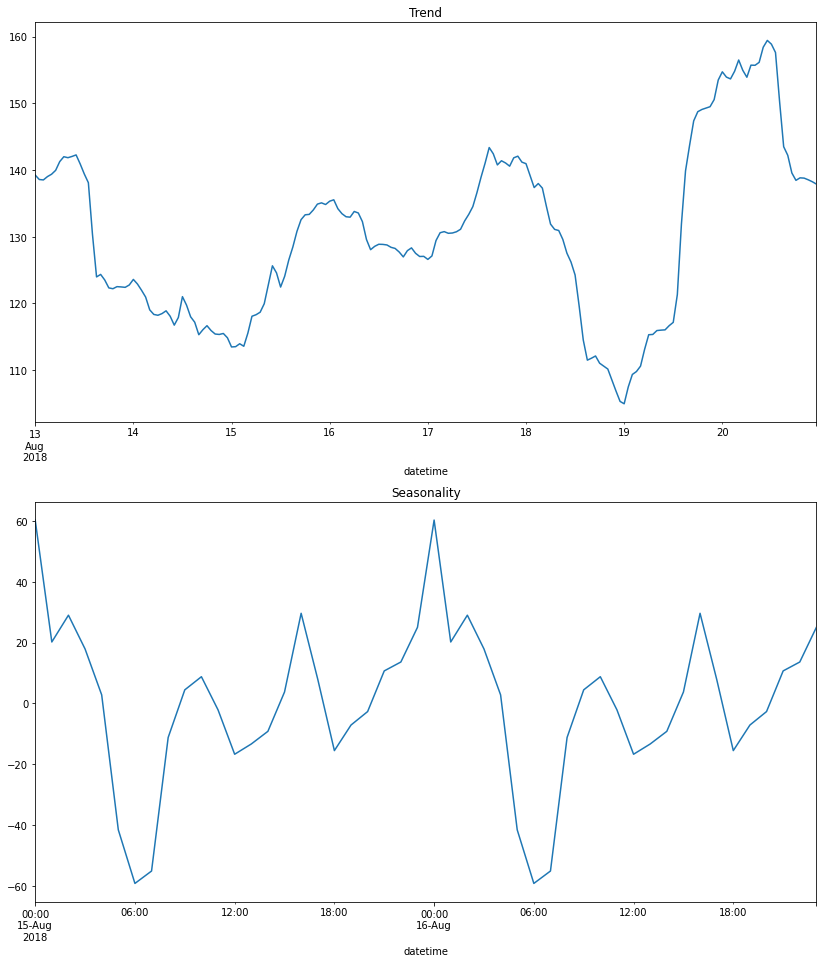

In [16]:
plt.figure(figsize = (14, 25))
plt.subplot(311);
df_trend['2018-08-13' : '2018-08-20'].plot(ax = plt.gca());
plt.title('Trend');

plt.subplot(312);
df_season['2018-08-15' : '2018-08-16'].plot(ax = plt.gca());
plt.title('Seasonality');

Можно сделать выводы, что:
    
1. Пики поездок по дням недели приходятся на понедельник, четверг и субботу, минимум - на воскресенье
2. Пики поездок по времени - в 17 и полночь, минимум - в 6 утра

## Обучение

### Подготовка данных и функций

Создадим функцию, формирующую датасеты с обучающей и тестовой выборками по target и features. Для этого будут формироваться признаки: месяц, день недели, лаги и скользящее среднее. На основе полученных столбцов обновленный датасет делится на 4 выборки: обучающая и тестовая выборки по target и features. Тестовая выборка составляет 10% от исходной.

In [17]:
def datasets(data, max_lag, rolling_mean_size):
    
    data['month'] = data.index.month
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    train, test = tts(data, test_size = 0.1, shuffle = False)
    train = train.dropna()
    
    features_train = train.drop(['num_orders'], axis = 1)
    target_train = train['num_orders']
    features_test = test.drop(['num_orders'], axis = 1)
    target_test = test['num_orders']
    
    return features_train, target_train, features_test, target_test

Создадим функцию, определяющую метрику RMSE обученной модели. На вход она получает: значение границ цикла for по гиперпараметрам `max_lag` и `rolling_mean_size`, алгоритм обучения. Она производит перебор по гиперпараметрам, кросс-валидацию, определяет значения метрик RMSE для обучающей и тестовой выборок. Если значение RMSE для тестовой выборки не более 48, данная модель принимается наилучшей, и метрики RMSE для обучающей и тестовой выборок выводятся.

In [18]:
def RSME_metric(data, min_lag, max_lag, min_roll, max_roll, model):
    
    best_lag = 0
    best_roll = 0

    for lag in range(min_lag, max_lag + 1):
        for roll in range(min_roll, max_roll + 1):
        
            created_datasets = datasets(data, lag, roll)
            model_learning = model

            model_learning.fit(created_datasets[0], created_datasets[1])


            scores = cross_val_score(model_learning, created_datasets[0], 
                            created_datasets[1], scoring = 'neg_mean_squared_error', cv = 5)
            final_score = -sum(scores) / len(scores)

            model_learning.fit(created_datasets[0], created_datasets[1])
            predictions_test = model_learning.predict(created_datasets[2])
        
            rmse_train = final_score ** 0.5
            rmse_test = sklm.mean_squared_error(created_datasets[3], predictions_test) ** 0.5
        
            if rmse_test <= 48:
                
                best_lag = lag
                best_roll = roll
                
                print('Значение RMSE на обучающей выборке:', rmse_train)
                print('Значение RMSE на тестовой выборке:', rmse_test)
                print('-----------------')
                print('Значение гиперпараметра max_lag:', best_lag)
                print('Значение гиперпараметра rolling_mean_size:', best_roll)
                
                break
        break
    return best_lag, best_roll

### Обучение на RF

Произведем обучение и тестирование на модели RandomForestRegressor с помощью функции `RSME_metric()` и определим значения RMSE на обучающей и тестовой выборках, а также значения гиперпараметров. Также проведем оптимизацию модели RF и определим наилучшие гиперпараметры:

In [19]:
df_RF = df.copy()

In [20]:
for est in range(4, 10):
    for depth in range(1, 10):

        result_RF = RSME_metric(data = df_RF, 
                                min_lag = 25, 
                                max_lag = 40, 
                                min_roll = 25, 
                                max_roll = 27, 
                                model = RandomForestRegressor(random_state = 12345, 
                                                              n_estimators = est, max_depth = depth))
        
        if result_RF[0] > 0:
            
            print('Значение гиперпараметра n_estimators:', est)
            print('Значение гиперпараметра max_depth:', depth)
            
            break
    break

Значение RMSE на обучающей выборке: 27.70035887677346
Значение RMSE на тестовой выборке: 47.31645228964911
-----------------
Значение гиперпараметра max_lag: 25
Значение гиперпараметра rolling_mean_size: 27
Значение гиперпараметра n_estimators: 4
Значение гиперпараметра max_depth: 6


### Обучение на LR

Произведем обучение и тестирование на модели LinearRegression с помощью функции `RSME_metric()` и определим значения RMSE на обучающей и тестовой выборках, а также значения гиперпараметров:

In [21]:
df_LR = df.copy()

In [22]:
result_LR = RSME_metric(data = df_LR, 
                        min_lag = 25, 
                        max_lag = 40, 
                        min_roll = 25, 
                        max_roll = 27, 
                        model = LinearRegression())

Значение RMSE на обучающей выборке: 26.19390534953634
Значение RMSE на тестовой выборке: 45.54345222839755
-----------------
Значение гиперпараметра max_lag: 25
Значение гиперпараметра rolling_mean_size: 25


## Тестирование

### Тестирование на моделях

Создадим функцию, определяющую качество модели по метрике RMSE с учетом подобранных гиперпараметров:

In [23]:
def test(data, lag, roll, model):
    
    created_datasets = datasets(data, lag, roll)
    
    model_learning = model
    model_learning.fit(created_datasets[0], created_datasets[1])
    predictions_test = model_learning.predict(created_datasets[2])    
    rmse_test = sklm.mean_squared_error(created_datasets[3], predictions_test) ** 0.5

    return created_datasets[3], predictions_test, rmse_test

Определим RMSE для тестовой выборки модели RF с учетом подобранных гиперпараметров, в том числе самой модели:

In [24]:
test(df_RF, 25, 27, RandomForestRegressor(random_state = 12345, n_estimators = 4, max_depth = 6))[2]

47.31645228964911

Определим RMSE для тестовой выборки модели LR с учетом подобранных гиперпараметров:

In [25]:
test(df_LR, 25, 25, LinearRegression())[2]

45.54345222839755

### Визуальный анализ качества моделей

Для визуального определения качества модели построим график с предсказаниями и действительными значениями моделей:

In [26]:
target_test_RF = test(df_RF, 25, 27, RandomForestRegressor(random_state = 12345, 
                                                           n_estimators = 4, max_depth = 6))[0].tolist()
predictions_test_RF = test(df_RF, 25, 27, RandomForestRegressor(random_state = 12345, 
                                                                n_estimators = 4, max_depth = 6))[1].tolist()
index_test_RF = test(df_RF, 25, 27, RandomForestRegressor(random_state = 12345, 
                                                          n_estimators = 4, max_depth = 6))[0].index

target_test_LR = test(df_LR, 25, 25, LinearRegression())[0].tolist()
predictions_test_LR = test(df_LR, 25, 25, LinearRegression())[1].tolist()
index_test_LR = test(df_LR, 25, 25, LinearRegression())[0].index

Создадим датасеты с  предсказаниями и действительными значениями моделей:

In [27]:
df_test_RF = pd.DataFrame(data = [target_test_RF, predictions_test_RF]).T
df_test_RF.index = index_test_RF
df_test_RF.columns = ['num_orders', 'prediction_orders']

df_test_LR = pd.DataFrame(data = [target_test_LR, predictions_test_LR]).T
df_test_LR.index = index_test_LR
df_test_LR.columns = ['num_orders', 'prediction_orders']

Построим графики для модели RF. Возьмем для сравнения 3 промежутка: 15-16, 21-22 и 30-31 августа:

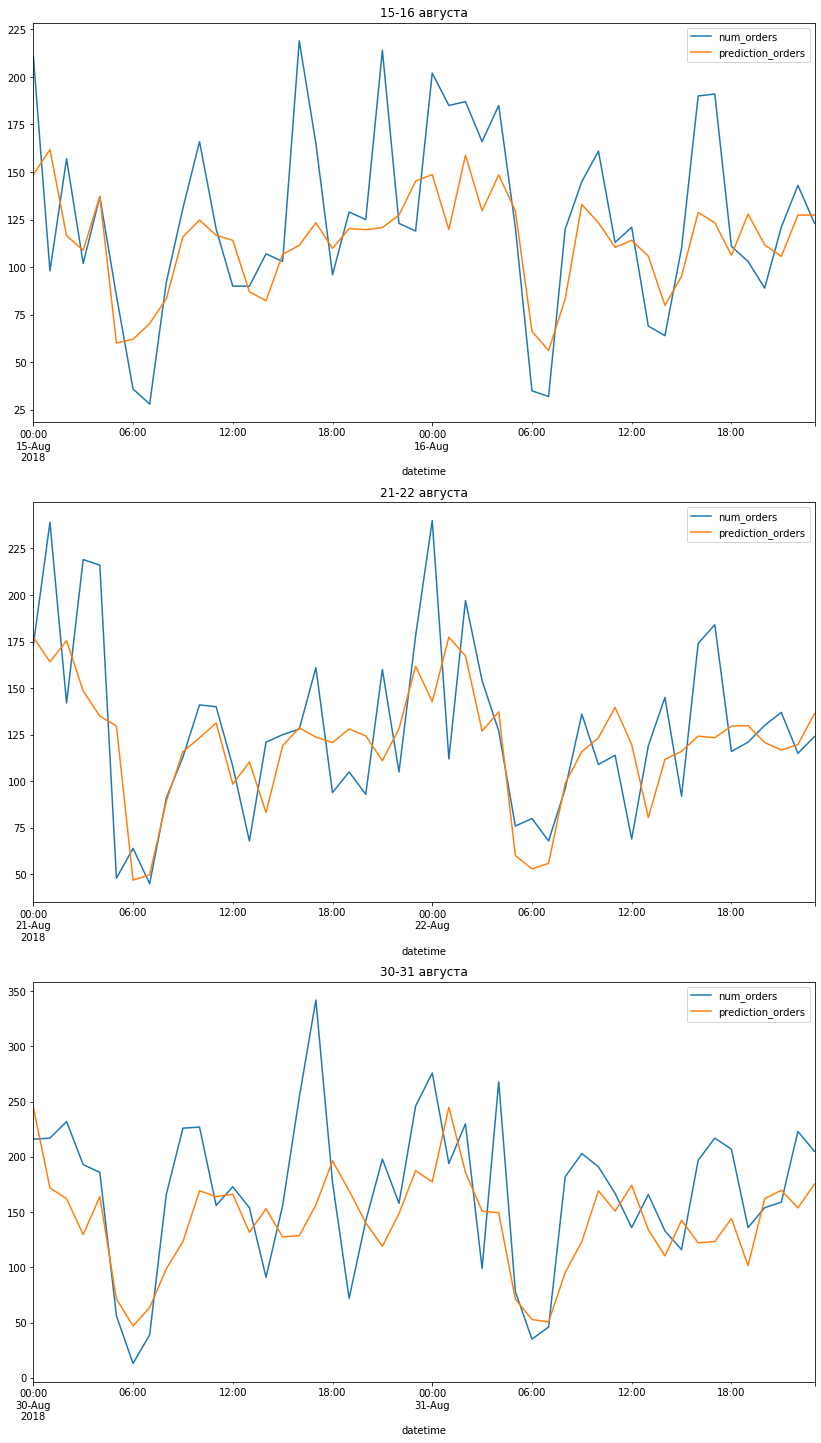

In [28]:
plt.figure(figsize = (14, 25))
plt.subplot(311);
df_test_RF['2018-08-15' : '2018-08-16'].plot(ax = plt.gca());
plt.title('15-16 августа');

plt.subplot(312);
df_test_RF['2018-08-21' : '2018-08-22'].plot(ax = plt.gca());
plt.title('21-22 августа');

plt.subplot(313);
df_test_RF['2018-08-30' : '2018-08-31'].plot(ax = plt.gca());
plt.title('30-31 августа');

Построим графики для модели LR. Возьмем для сравнения 3 промежутка: 15-16, 21-22 и 30-31 августа:

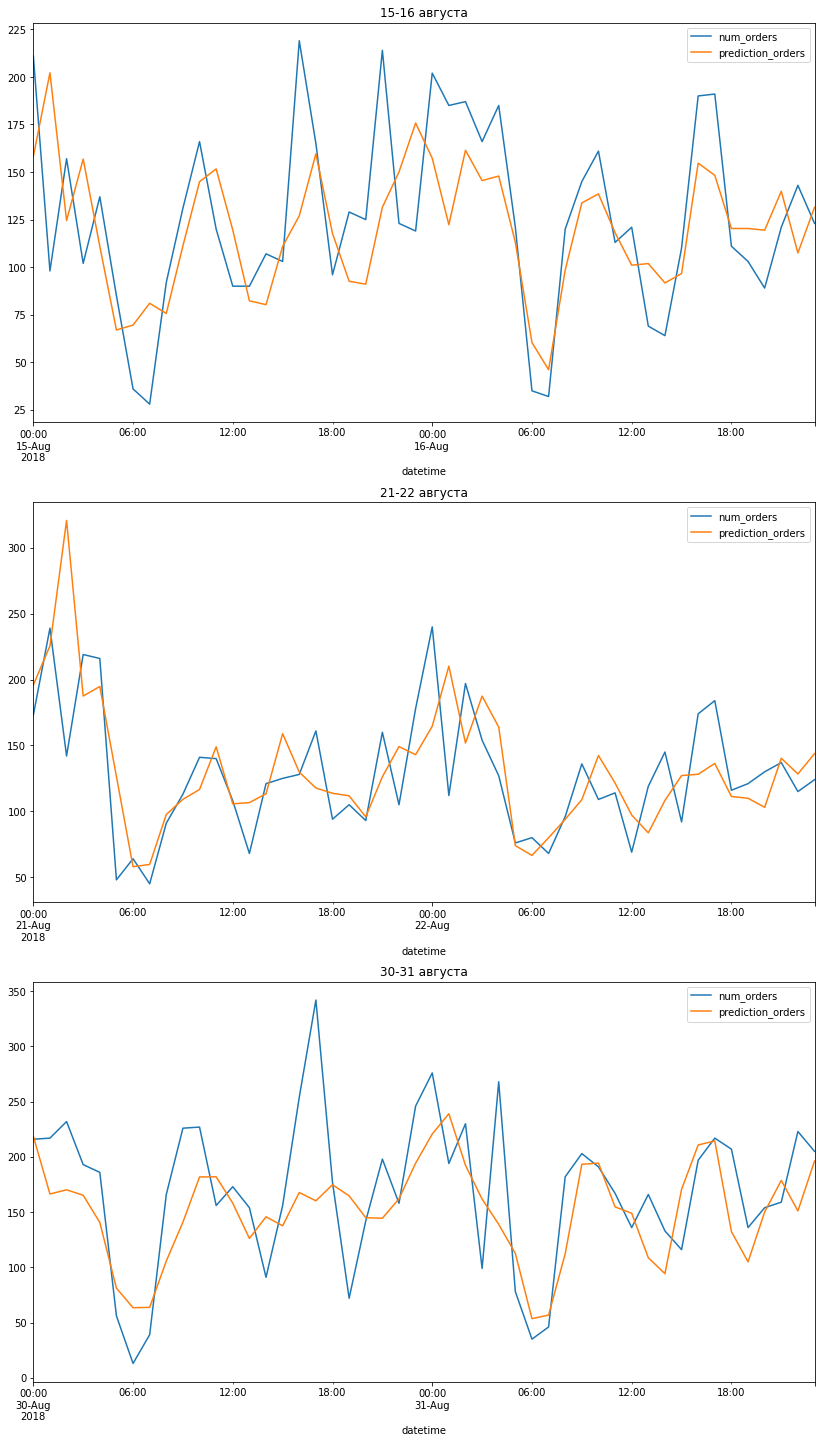

In [29]:
plt.figure(figsize = (14, 25))
plt.subplot(311);
df_test_LR['2018-08-15' : '2018-08-16'].plot(ax = plt.gca());
plt.title('15-16 августа');

plt.subplot(312);
df_test_LR['2018-08-21' : '2018-08-22'].plot(ax = plt.gca());
plt.title('21-22 августа');

plt.subplot(313);
df_test_LR['2018-08-30' : '2018-08-31'].plot(ax = plt.gca());
plt.title('30-31 августа');

Из графиков можно получить следующие выводы:

1. Модели улавливают тенденции изменения количества заказов по часам
2. Работая с заданной точностью (RMSE не более 48), модели осредняют количество заказов, поэтому расхождения с пиками заказов может быть значительным; например, 30 августа по реальным данным пик заказов приходится на 17 часов, при этом модели предсказывают только половину от реальных заказов 

## Выводы

В ходе выполнения проекта были произведены: подготовка данных, их анализ, обучение и тестирование моделей.

В процессе выполнения подготовки данных данные были преобразованы согласно формату даты / времени, были произведены проверка индексов датасета на монотонность и проверка на пропуски, а также проведено ресемплирование по одному часу.

В процессе анализа данныхбыли произведены:
1. Анализ данных за весь период
2. Добавлены и проанализированы плавающее среднее и стандартное отклонение
3. Анализ данных по тренду, сезонности и остатку, получены следующие выводы:
    1. Количество заказов постоянно увеличивается (минимум - в марте, максимум - в сентябре)
    2. Сезонность постоянная и колебается с амплитудой 60 (необходимо уточнить)
    3. Остатки примерно до августа колебаются в одинаковом диапазоне (амплитуда примерно 35-40), далее к сентябрю амплитуда  
    увеличивается примерно до 50, а также увеличиваются случайные значения
4. Анализ данных в отдельных периодах, получены следующие выводы в марте:
    1. Пик поездок по дням недели приходится на пятницу и субботу, минимум - на воскресенье
    2. Пики поездок по времени - в 17 и полночь, минимум - в 6 утра
    В августе:
    1. Пики поездок по дням недели приходятся на понедельник, четверг и субботу, минимум - на воскресенье
    2. Пики поездок по времени - в 17 и полночь, минимум - в 6 утра
   
В процессе обучения и тестирования были созданы функции `datasets()` - формирующая датасеты с обучающей и тестовой выборками по target и features, а также создающая признаки и `RSME_metric()` - определяющая значения RMSE на обучающей и тестовой выборках на лучших значениях гиперпараметров. Получены результаты:
1. Значение RMSE на обучающей выборке для RF - 27.70035887677346
2. Значение RMSE на тестовой выборке для RF - 47.31645228964911
3. Значение гиперпараметра max_lag для RF - 25
4. Значение гиперпараметра rolling_mean_size для RF - 25
5. Значение гиперпараметра n_estimators для RF - 4
6. Значение гиперпараметра max_depth для RF - 6


1. Значение RMSE на обучающей выборке для LR - 26.19390534953634
2. Значение RMSE на тестовой выборке для LR - 45.54345222839755
3. Значение гиперпараметра max_lag для LR - 25
4. Значение гиперпараметра rolling_mean_size для LR - 25

Значения RMSE на тестовых выборках менее 48, основной критерий проекта выполнен.

Во время тестирования моделей также были построены графики сравнения реальных и предсказанных заказов, получены следующие выводы:

1. Модели улавливают тенденции изменения количества заказов по часам
2. Работая с заданной точностью (RMSE не более 48), модели осредняют количество заказов, поэтому расхождения с пиками заказов может быть значительным; например, 30 августа по реальным данным пик заказов приходится на 17 часов, при этом модели предсказывают только половину от реальных заказов 